In [1]:
import torch
import torch.nn as nn 
import os 
import numpy as np 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from jiwer import cer 

**credits**: The following code is heavily inspired by 
- https://github.com/cmudeeplearning11785/Fall2018-tutorials/blob/master/recitation-8/ctc_handwritten_digit_reader.ipynb

### generate and load data

In [48]:
datasetpath = "data/seq_mnist_dataset"
# check if data already exists and synthesize if not
if not os.path.exists(datasetpath) or (os.listdir(datasetpath)) == 0:
    import src.data.mkSeqMNIST as data_synthesizer
    data_synthesizer.make()

# loading the dataset 
data, labels = np.load(datasetpath+"/data.npy"), np.load(datasetpath+"/labels.npy")

print("Data shape:", data.shape) 
print("(num_samples, height, width)\n")
print("Labels shape: ", labels.shape) 
print("max images: ", np.max(data)) 
data = data.clip(0, 255) / 255.0 


Data shape: (20000, 36, 172)
(num_samples, height, width)

Labels shape:  (20000, 10)
max images:  510.0


### model architecture

In [49]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__() 
        self.embed = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=(2, 1), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=(2, 2), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False),
            nn.ELU()
        )
        dim = 288
        hidden_size = 256
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden_size)
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=10 + 1)

    def forward(self, features):
        # features: n, 1, h, w
        embedding = self.embed(features)
        n, c, h, w = embedding.size() 
        embedding = embedding.view(n, c*h, w).permute(2, 0, 1)
        # embed: t, n, f
        h, _ = self.lstm(embedding)
        logits = self.output_layer(h)
        
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        return log_probs    

### constants 

In [50]:
# train/test split
split = 0.8
batch_size = 32
max_epochs = 1000
blank = 10 

### data preprocessing

In [51]:

split_idx = int(split*len(data))

train_set = TensorDataset(
    torch.tensor(data[:split_idx], dtype=torch.float32),
    torch.tensor(labels[:split_idx], dtype=torch.long)
)

test_set = TensorDataset(
    torch.tensor(data[split_idx:], dtype=torch.float32),
    torch.tensor(labels[split_idx:], dtype=torch.long)
)

loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

### model training

In [52]:
model = CNNLSTM() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = torch.nn.CTCLoss(blank=10) 

In [54]:
for i in range(max_epochs):
    image, label = next(iter(loader))
    image = image.unsqueeze(1) # (b, 1, h, w) 
    
    
    # print("max image:", image.max())
    # print("min image:", image.min())
        
    if i == 0:
        print("image shape:", image.shape) 
        print("label shape:", label.shape) 
        print("image min:", image.min())
        print("image max:", image.max())
    optimizer.zero_grad()
    log_probs = model(image)
    
    if i == 0:
        print("log_probs shape:", log_probs.shape)
        
    input_lengths = torch.full((batch_size,), log_probs.size(0), dtype=torch.long)
    target_lengths = torch.full((batch_size,), label.size(1), dtype=torch.long) 
   
    
    loss = criterion(log_probs, label, input_lengths, target_lengths)
    loss.backward()
    if i % 10 == 0:
        print("Loss:", loss.item())
    optimizer.step()
    
    
    

image shape: torch.Size([32, 1, 36, 172])
label shape: torch.Size([32, 10])
image min: tensor(0.)
image max: tensor(1.)
log_probs shape: torch.Size([86, 32, 11])
Loss: 2.818044900894165
Loss: 2.541199207305908
Loss: 2.5316245555877686
Loss: 2.505690336227417
Loss: 2.5135812759399414
Loss: 2.503389358520508
Loss: 2.5378878116607666
Loss: 2.483454704284668
Loss: 2.501626968383789
Loss: 2.4912540912628174
Loss: 2.505733013153076
Loss: 2.480006694793701
Loss: 2.50415301322937
Loss: 2.5003230571746826
Loss: 2.4862279891967773
Loss: 2.4635331630706787
Loss: 2.469348907470703
Loss: 2.4492480754852295
Loss: 2.457345724105835
Loss: 2.4324872493743896
Loss: 2.4376089572906494
Loss: 2.4711666107177734
Loss: 2.4361658096313477
Loss: 2.4299511909484863
Loss: 2.427051305770874
Loss: 2.402113437652588
Loss: 2.4163923263549805
Loss: 2.3941104412078857
Loss: 2.363715887069702
Loss: 2.3863911628723145
Loss: 2.3356447219848633
Loss: 2.3273184299468994
Loss: 2.3126585483551025
Loss: 2.2897226810455322
Los

In [55]:
def greedy_decode(log_probs, blank_index):
    """
    Decode using greedy method.
    :param log_probs: Log probabilities from the model (T x V)
    :param blank_index: Index of the blank token
    :return: Decoded sequence as a string
    """
    max_indices = np.argmax(log_probs, axis=1)  # Argmax over vocabulary
    sequence = ""
    previous = None
    vocab = [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9",""] 
    
    for index in max_indices:
        if index != previous:  # Skip consecutive duplicates
            if index != blank_index:  # Skip blank tokens
                sequence += vocab[index]
        previous = index

    return sequence

Predicted text: 8470894784
True text: 8470894784
CER: 0.0


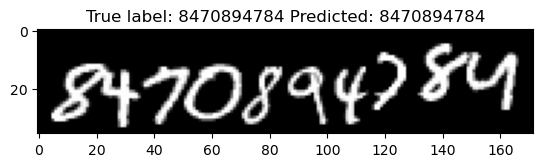

Predicted text: 795427719
True text: 7952427719
CER: 0.1


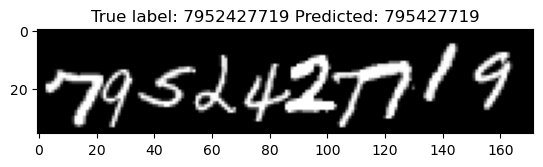

Predicted text: 3266476868
True text: 3266476868
CER: 0.0


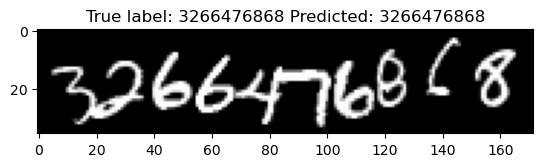

Predicted text: 3813448283
True text: 3813742283
CER: 0.2


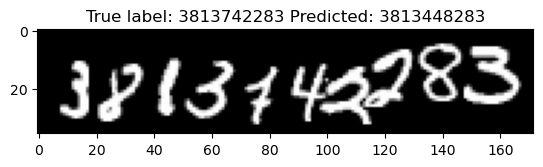

Predicted text: 359022347
True text: 3870222347
CER: 0.3


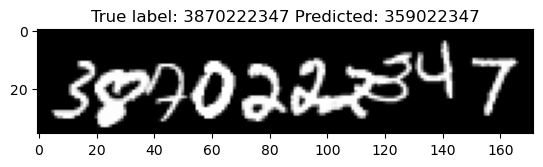

In [56]:
for i in range(5): 
    image = test_set[i][0]
    label = test_set[i][1]
    
    label_str = "".join([str(i) for i in label.numpy() ])  
    plt.imshow(image.squeeze(), cmap="gray")
    
    
    predicted = model(image.unsqueeze(0).unsqueeze(0)).detach() # (1, 1, h, w)
    predicted_text = greedy_decode(predicted.squeeze().detach().numpy(), blank)
    print("Predicted text:", predicted_text)
    print("True text:", label_str)
    print("CER:", cer(label_str, predicted_text))
    plt.title("True label: " + label_str + " Predicted: " + predicted_text)
    plt.show()
    

In [20]:
avg_cer = 0
for image,label in test_set: 
    predicted = model(image.unsqueeze(0).unsqueeze(0)).detach() # (1, 1, h, w)
    label = "".join([str(i) for i in label.numpy() ]) 
    predicted_text = greedy_decode(predicted.squeeze().detach().numpy(), blank)
    curr_cer = cer(predicted_text, label) 
    avg_cer += curr_cer    
print("Average CER:", avg_cer/len(test_set))

Average CER: 0.0381386093073594
